In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bs4
import os
import requests
import re
import pprint

import nltk
from wordcloud import WordCloud
import base64
import string
import nltk

from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
#!pip install pywaffle
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [7]:
def re_request(url, headers=None):
    request = requests.get(url, headers=headers)
    try:
        request.status_code == 200
    except ValueError:
        print(f"code {request.status_code}")
    return bs4.BeautifulSoup(request.content, "html.parser")

### Pymongo test

docker run --name test-mongodb -d -p 27017:27017 mongo:latest
docker exec -it test-mongo bash

prochaine étape les volumes!


### Pokémon

In [111]:
base_url = "https://pokemondb.net/pokedex/"
url_liste = base_url + "national"
headers = {'User-Agent': 'Mozilla/5.0'}

def get_pokedex():
        url_liste = base_url + "national"
        pokemons = re_request(url_liste, headers=headers).find_all(class_ = "infocard")
        pokedex = dict()
        for pokemon in pokemons:
                numero = pokemon.find_all('small')[0].get_text()
                poki = {
                        'nom' : pokemon.find(class_='ent-name').get_text(),
                        'type' : pokemon.find_all('small')[1].get_text().split(' · ')
                        }
                pokedex[int(re.findall(r"\d+", numero)[0])] = poki
        return pokedex

In [112]:
## pour plus de robustesse, faire une fonction regex qui supprime et nettoie les urls à la place de ce dictionnaire naze
def get_pokemon(numero, headers=headers):
    pokedex = get_pokedex()
    remplacement = {
        ' ': '-',
        '♀' : '-f',
        '♂' : '-m',
        '.' : '',
        'é' : 'e',
        ':' : '',
        "'" : '',
    }
    poke_name = pokedex[numero]['nom'].lower()
    for key, value in remplacement.items():
        poke_name = poke_name.replace(key, value)
    
    url_pokemon =  base_url + poke_name
    pokemon = dict()
    for i in re_request(url_pokemon, headers=headers).find_all(class_ = "vitals-table")[:4]:
        for data in i.find_all('tr'):
            pokemon[data.find('th').get_text()] = data.find('td').get_text().replace("\n", "")
    return {**pokemon, **pokedex[numero]}

data_pokemon = get_pokemon(718)
pprint.pprint(data_pokemon)
    

{'Abilities': '1. Aura Break2. Power Construct',
 'Attack': '100',
 'Base Exp.': '270',
 'Base Friendship': '0 (lower than normal)',
 'Catch rate': '3 (0.4% with PokéBall, full HP)',
 'Defense': '121',
 'EV yield': '3 HP ',
 'Egg Groups': 'Undiscovered',
 'Egg cycles': '120 (30,584–30,840 steps)',
 'Gender': 'Genderless',
 'Growth Rate': 'Slow',
 'HP': '108',
 'Height': '5.0\xa0m (16′05″)',
 'Local №': '150 (X/Y — Mountain Kalos)205 (Sun/Moon — Alola dex)263 '
            '(U.Sun/U.Moon — Alola dex)',
 'National №': '718',
 'Sp. Atk': '81',
 'Sp. Def': '95',
 'Species': 'Order Pokémon',
 'Speed': '95',
 'Total': '600',
 'Type': 'Dragon Ground ',
 'Weight': '305.0\xa0kg (672.4\xa0lbs)',
 'nom': 'Zygarde',
 'type': ['Dragon', 'Ground']}


In [115]:
#Ajouter des tests pour être sur que toutes les données puissent entrer.
class CleanData:
    def __init__(self, pokemon):
        self.data = {
        'id' : CleanData.get_id(pokemon),
        'name' : CleanData.get_name(pokemon),
        'type' : CleanData.get_type(pokemon),
        'base_stats' : CleanData.get_base_stats(pokemon),
        'ev' : CleanData.get_ev(pokemon),
        'weight' : CleanData.get_weight(pokemon),
        'height' : CleanData.get_height(pokemon),
        'base_experience' : CleanData.get_base_experience(pokemon),
        'egg_group' : CleanData.get_egg_group(pokemon),
        'abilites' : CleanData.get_abilities(pokemon)
        }
    
    def get_id(pokemon): return int(pokemon['National №'])
    
    def get_name(pokemon): return pokemon['nom'].lower()
    
    def get_type(pokemon): return [item.lower() for item in pokemon['type']]
    
    def get_base_stats(pokemon) : 
        base_stats_col = {
            'HP' : 'hp', 
            'Attack' : 'attack', 
            'Defense' : 'defense', 
            'Sp. Atk' : 'special_attack', 
            'Sp. Def' : 'special_defense', 
            'Speed' : 'speed', 
            'Total' : 'total'
        }
        
        return {value : int(pokemon[key]) for key, value in base_stats_col.items()}
    
    def get_ev(pokemon): return {item[1:].strip().lower().replace(' ', '_') : int(item[0]) for item in [test.strip() for test in pokemon['EV yield'].split(',')]}
    
    def get_weight(pokemon): return float(pokemon['Weight'].split('\xa0')[0])
    
    def get_height(pokemon): return float(pokemon['Height'].split('\xa0')[0])
    
    def get_base_experience(pokemon): return float(pokemon['Base Exp.'])
    
    def get_egg_group(pokemon): return [item.lower().strip() for item in pokemon['Egg Groups'].split(',')]
    
    def get_abilities(pokemon):
        
        clean = lambda x: x.replace('.', '').replace('(hidden ability)', '').strip()
        def lower_replace(liste): return [item.replace(' ', '_').lower() for item in liste]
        
        def separate_hidden_talent(string):
            liste_str = [item for item in string]
            for i, value in enumerate(liste_str):
                if value.islower() and liste_str[i+1].isupper():
                    break
            return ''.join(liste_str[:i+1]), ''.join(liste_str[i+1:])
        
        pokemon_abilites_str = pokemon['Abilities']
        abilities = [clean(item) for item in re.split(r'[0-9]', pokemon_abilites_str) if not clean(item) == '']
        
        if 'hidden ability' not in pokemon_abilites_str:
            return lower_replace(abilities)
        else:
            if len(abilities) == 1:
                return lower_replace(list(separate_hidden_talent(abilities[0])))
            else:   
                return lower_replace([abilities[0]] + list(separate_hidden_talent(abilities[-1])))
  

In [ ]:
import pymongo
client = pymongo.MongoClient(f"mongodb://127.0.0.1:27017/", username='root', password='example')
db = client["dbpokedex"]
pkdx = db["pokedex"]
for id in range(865, 899):
    pkdx.insert_one(CleanData(get_pokemon(id)).data)

In [ ]:
def get_dataframe(n_col=10):
    liste = []
    for poki in range(1, n_col+1):
        liste.append({'name' : pokedex[poki]['nom'], **get_pokemon(poki)})  
    return pd.DataFrame(liste)

### Ministre français

In [ ]:
url_min = 'https://fr.wikipedia.org/wiki/Gouvernement_de_la_R%C3%A9publique_fran%C3%A7aise'
headers = {'User-Agent': 'Mozilla/5.0'}
data = re_request(url_min, headers=headers)

In [ ]:
driver = webdriver.Chrome()
driver.get(url_min)

### Musique française, le rap

on cherche à créer un base élastic search avec pleins d'info sur chaque rappeur. Ainsi que leur texte. Cela nous permettra d'analyser un peu le comportement ainsi que de faire du NLP

In [8]:
## on récupère tous les auteurs d'un top de fan de rap

def artistes(x):
    url_rappeur = lambda x : f"https://www.senscritique.com/liste/les_meilleurs_rappeurs_francais/1266999?page={x}"
    name = lambda x : re.split(r'\d+\.', x.get_text())[-1].strip()

    ## on récupère l'information du nombre de page
    nombre_page = int(re_request(url_rappeur(1)).find_all(class_='Text__SCTitle-sc-14ie3lm-1 Pagination__Item-sc-u5kybx-1 Pagination__PaginationItem-sc-u5kybx-2 ebkcFF jTRycw cLqjhv')[-1].get_text())

## on crée la boucle qui itère sur toutes les pages 
    auteurs = []
    for i in range(1, nombre_page+1):
        auteurs += [name(item) for item in re_request(url_rappeur(i)).find_all(class_='Text__SCText-sc-14ie3lm-0 cECGzP')]
    
# on nettoie un minimum les noms, pas parfait mais fait le taf
# une utililisation judicieuse des regex pourrait faire plus propement le taf
    def nettoyage_name(auteur):
        liste_nettoyage = [' ', "'", '.', "’"]
        for item in liste_nettoyage:
            auteur = auteur.replace(item, '-')
        return auteur.lower()

    auteurs = [nettoyage_name(auteur) for auteur in auteurs]
    return auteurs[:x]

In [9]:
liste_auteurs = artistes(4)

In [12]:
## pour 1 artiste donne l'ensemble des albums ainsi que que va chercher l'ensemble des paroles de tous les titres associées
## trouver une méthode pour stocker tout ces textes.
## meilleur idée serait de tout stocker dans base mongo db ou elastic search
class Artiste:
    #je rajoute un argument pour ne recupérer qu'un certain nombre d'album
    def __init__(self, artiste, n_album=2):
        self.artiste = artiste
        self.albums = Artiste.get_albums(artiste, n_album)
             
    @staticmethod
    def get_albums(artiste, n_album):
        url_genius_artiste = f"https://genius.com/artists/{artiste}"
        return [Album(item["title"], item["href"]) 
                              for item in re_request(url_genius_artiste).find_all(class_="vertical_album_card")[:n_album]]
            
class Album:
    def __init__(self, album, url):
        self.album = Album.clean_album_name(album)
        self.songs, self.date = Album.get_songs_date(url)
        
    @staticmethod
    def get_songs_date(url):
        request_albums_songs = re_request(url)
        release_year_brut = request_albums_songs.find(class_= 'metadata_unit').get_text()
        release_year = int(re.findall(r'[0-9]{4}', release_year_brut)[0])
        
        songs_brut = request_albums_songs.find_all(class_='chart_row-content')
        songs = [Song(song.find("h3").get_text().replace('Lyrics', '').strip(), song.find(class_="u-display_block")['href']) 
                                                                for song in songs_brut] 
        return  songs, release_year
        
    @staticmethod
    def clean_album_name(album):
        return re.sub(r'\(.*\)', '', album).strip().lower().replace(' ', '-')       
class Song:
    def __init__(self, song, url):
        self.song = Song.clean_song_name(song)
        self.url = url
        self.lyrics = Song.get_song(url)
    
    @staticmethod
    def get_song(url):
        song = re_request(url).find(class_='Lyrics__Container-sc-1ynbvzw-6 YYrds')
        song = str(song).replace('<br/>', '. ')
        song =  bs4.BeautifulSoup(song, "html.parser")
        return re.sub(r"\[.*?\]", "", song.get_text())
    
    @staticmethod
    def clean_song_name(song):
        return re.sub(r'\(.*\)', '', song).strip().lower().replace(' ', '-')
    
    @staticmethod    
    def bag_of_words(lyrics):
        ...
        
def artiste_to_dic_songs(artiste):
    return [{
                "artiste" : artiste.artiste,
                "album" : album.album,
                "release_year" : album.date,
                "title" : song.song,
                "lyric" : song.lyrics
            } 
                for album in artiste.albums for song in album.songs ]

L'idéal maintenant serait de stocker l'ensembles des musiques liés à un artiste dans une database du type mongo db on peut pour ça réutiliser la structure précédente

In [13]:
oxmo = Artiste(liste_auteurs[-1])

In [14]:
test = artiste_to_dic_songs(oxmo)

In [143]:
import pymongo
client = pymongo.MongoClient(f"mongodb://127.0.0.1:27017/", username='root', password='example')
db = client["musique"]
rap = db["rap"]
for auteur in artistes(4):
    rap.insert_many(artiste_to_dic_songs(Artiste(auteur)))

In [ ]:
## maintenant on peut créer un bag of words contenant l'ensmeble des mots pour 1 auteur et puis traiter le contenu

In [83]:
musique = pd.DataFrame()
for auteur in artistes(50):
    songs = artiste_to_dic_songs(Artiste(auteur))
    for song in songs:
        dfi = pd.DataFrame([song])
        musique = pd.concat([musique, dfi])
musique.reset_index(drop=True, inplace=True)

#maintenant il ne reste plus qu'a créer un bag of words pour chaque chanson puis alimenter une bdd du style de elastic seach avec

In [327]:
group_artiste = musique.groupby('artiste')['lyric'].sum()
artiste_to_drop = ['ill', 'booba']
group_artiste.drop(artiste_to_drop, inplace=True)

In [328]:
corpora = dict()
tokenizer = nltk.RegexpTokenizer(r'\w+')
for index, value in group_artiste.items():
    corpora[index] = tokenizer.tokenize(value.lower())


stats, freq = dict(), dict()
for k, v in corpora.items():
        freq[k] =  fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())} 


<AxesSubplot: title={'center': 'Distribution du nombre de mots'}>

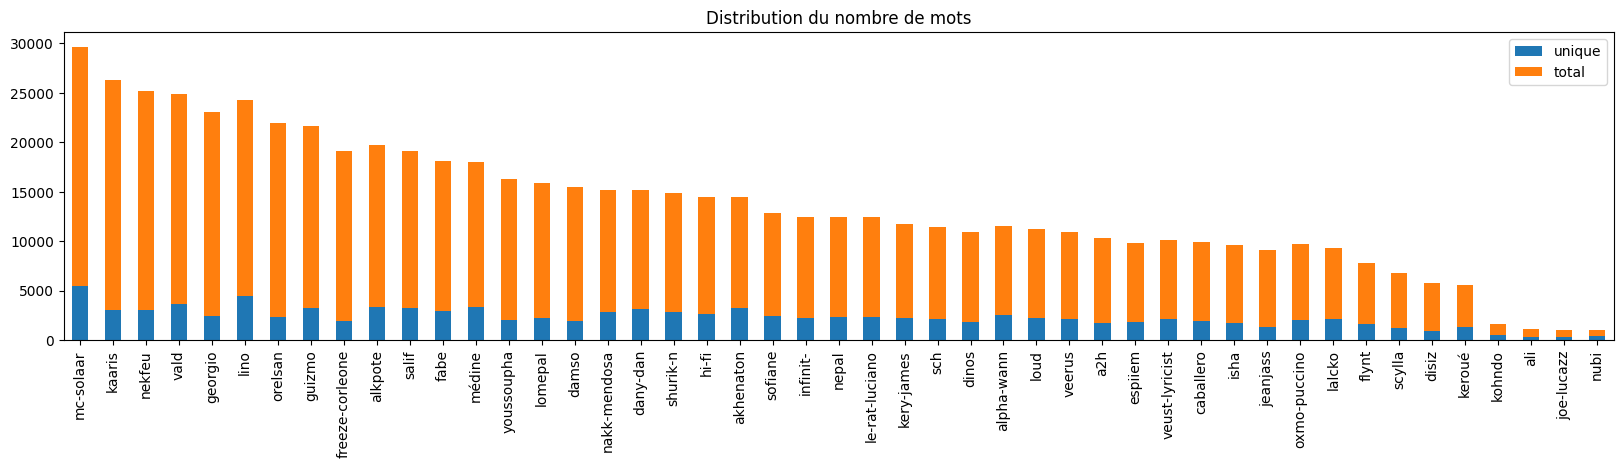

In [329]:
df = pd.DataFrame.from_dict(stats, orient='index').sort_values('total' ,ascending=False)
df.plot.bar(y=['unique', 'total'], stacked=True, title='Distribution du nombre de mots', figsize=[20, 4])

In [355]:
## on determine maintenant les stopwords à utliser, cad les mots qui seront ignorées
freq_totale = nltk.Counter()
for k, v in corpora.items():
    freq_totale += freq[k]
most_freq = [i[0] for i in freq_totale.most_common(100)]

stop_words = set()
stop_words.update(most_freq)
stop_words.update(tuple(nltk.corpus.stopwords.words('french')))
stop_words.update(('mais', 'ou', 'et', 'donc', 'or', 'ni', 'car'))

In [356]:
from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()

corpora2 = dict()
for key, value in corpora.items():
    corpora2[key] = [stemmer.stem(w) for w in value if not w in list(stop_words)]
    
stats2, freq2 = dict(), dict()
for k, v in corpora2.items():
        freq2[k] =  fq = nltk.FreqDist(v)
        stats2[k] = {'total': len(v), 'unique': len(fq.keys())} 

<AxesSubplot: title={'center': 'Distribution du nombre de mots'}>

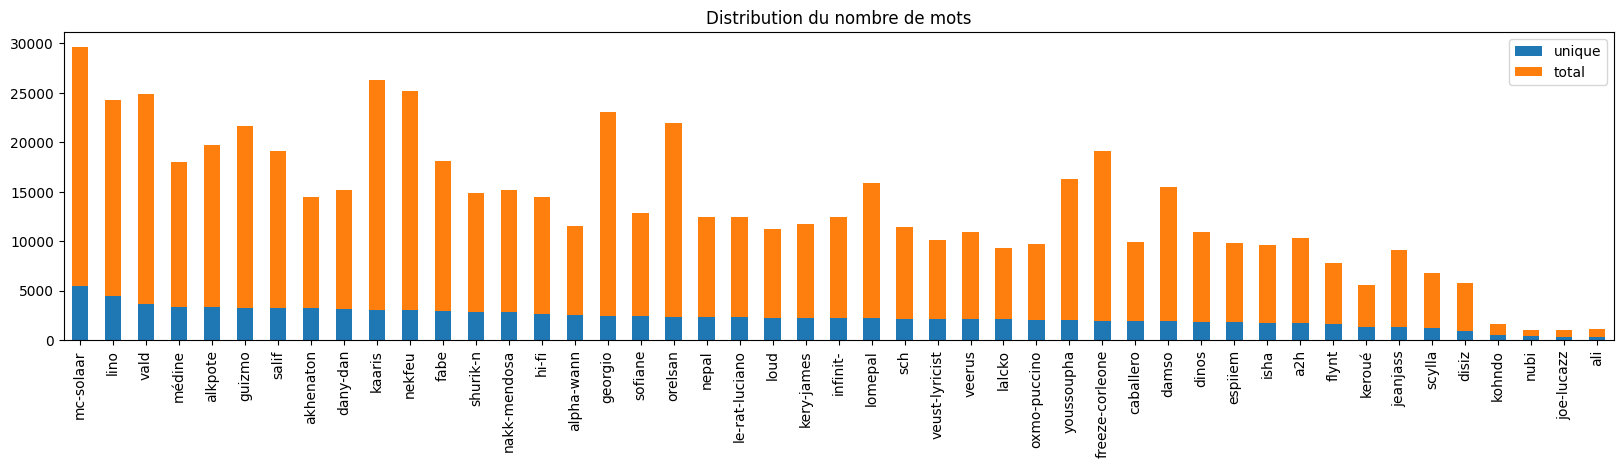

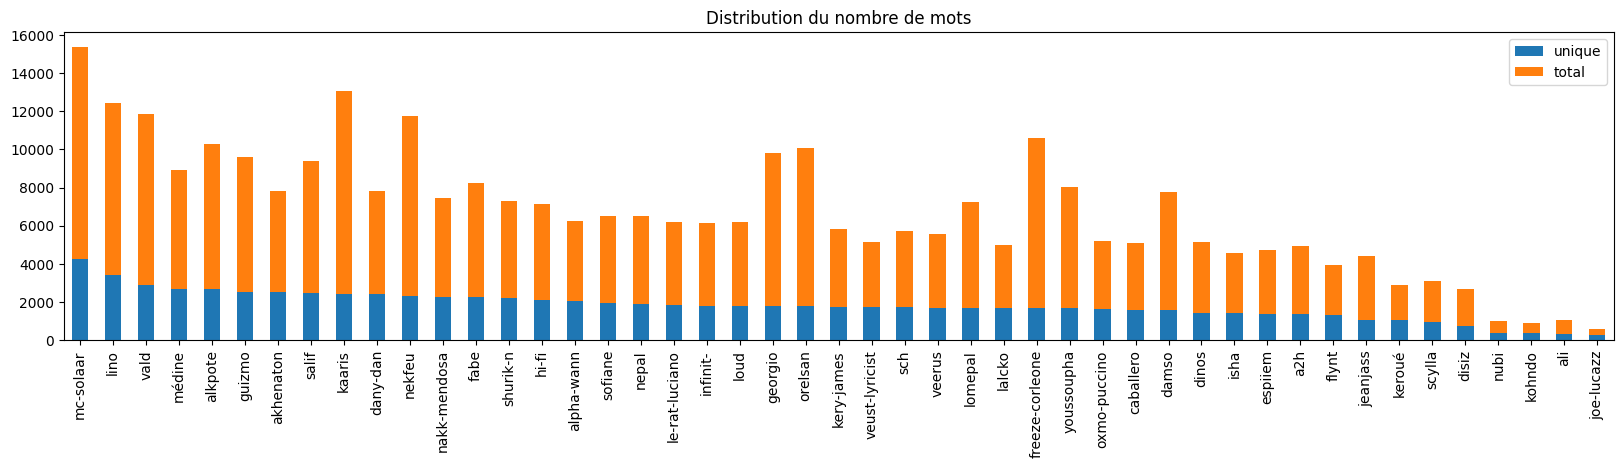

In [357]:
df = pd.DataFrame.from_dict(stats, orient='index').sort_values('unique' ,ascending=False)
df.plot.bar(y=['unique', 'total'], stacked=True, title='Distribution du nombre de mots', figsize=[20, 4])

df2 = pd.DataFrame.from_dict(stats2, orient='index').sort_values('unique' ,ascending=False)
df2.plot.bar(y=['unique', 'total'], stacked=True, title='Distribution du nombre de mots', figsize=[20, 4])

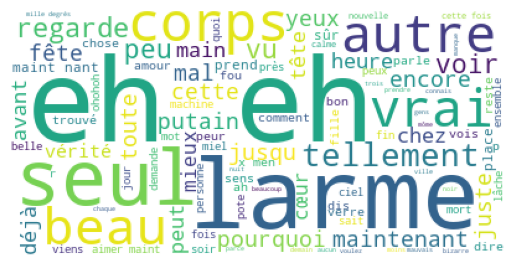

In [365]:
orelsan = ' '.join(tokenizer.tokenize(group_artiste['lomepal'].lower()))
wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=100).generate(orelsan)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()